In [1]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [2]:
from giant_learning.poly_poly import ProjectedH3H3Overlaps
from giant_learning.gradient_descent import ProjectedGradientDescent

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth

p = 4
k = 2
d = 2**10
T = 100
noise = 1e-6
n = int(np.power(d,1.85))
t = 1./np.sqrt(d)  
gamma = .05 * n * p * np.power(d,-3/2)
seed = 1
ic_seed = 0

target = ProjectedH3H3Overlaps._target
activation = ProjectedH3H3Overlaps._activation
activation_derivative = ProjectedH3H3Overlaps._activation_derivative
offdiag = (False if n == 1 else True)


sim_plainsgd_test_errors = np.zeros((T+1))
sim_correlationsgd_test_errors = np.zeros((T+1))
sim_adaptivesgd_test_errors = np.zeros((T+1))
theo_plainsgd_test_errors = np.zeros((T+1))
theo_correlationsgd_test_errors = np.zeros((T+1))
theo_adaptivesgd_test_errors = np.zeros((T+1))

## Initial condition
rng = np.random.default_rng(ic_seed)
init_corr = 1/np.sqrt(d)
Wtarget = orth((normalize(rng.normal(size=(k,d)), axis=1, norm='l2')).T).T
Wtild = normalize(rng.normal(size=(p,d)), axis=1, norm='l2')
Wtild_target = np.einsum('ji,ri,rh->jh', Wtild , Wtarget ,Wtarget)
W0_orth =  normalize(Wtild - Wtild_target, axis=1, norm='l2')
W0 = (init_corr*normalize(Wtild_target,norm='l2',axis=1) + np.sqrt(1-init_corr**2)*W0_orth)
a0 = np.ones(p)

P = Wtarget @ Wtarget.T
M0 = W0 @ Wtarget.T
Q0 = W0 @ W0.T

# Assert same 
if M0[0,0] < 0:
    W0 = -W0
    M0 = -M0

gd_plain = ProjectedGradientDescent(
    target, Wtarget, n,
    activation, W0, a0, activation_derivative,
    gamma, noise, predictor_interaction=True,
    test_size = None, analytical_error= 'H3H3',
    seed = seed
)

gd_corr = ProjectedGradientDescent(
    target, Wtarget, n,
    activation, W0, a0, activation_derivative,
    gamma, noise, predictor_interaction=False,
    test_size = None, analytical_error= 'H3H3',
    seed = seed
)

gd_adaptive = ProjectedGradientDescent(
    target, Wtarget, n,
    activation, W0, a0, activation_derivative,
    gamma, noise, predictor_interaction='adaptive',
    test_size = None, analytical_error= 'H3H3',
    seed = seed
)

gd_adaptive._adaptive_percentage_threshold = 0.6

gd_plain.train(T, verbose = True)
gd_corr.train(T, verbose = True)
# gd_adaptive.train(T, verbose = True)

sim_plainsgd_test_errors = np.array(gd_plain.test_errors)
sim_correlationsgd_test_errors = np.array(gd_corr.test_errors)
# sim_adaptivesgd_test_errors = np.array(gd_adaptive.test_errors)


## Theoretical predictions
theo_plain = ProjectedH3H3Overlaps(
    P, M0, Q0, a0,
    gamma, noise,
    I4_diagonal=d/n, I4_offdiagonal=offdiag,
    predictor_interaction=True
)

theo_corr = ProjectedH3H3Overlaps(
    P, M0, Q0, a0,
    gamma, noise,
    I4_diagonal=d/n, I4_offdiagonal=offdiag,
    predictor_interaction=False
)

theo_adaptive = ProjectedH3H3Overlaps(
    P, M0, Q0, a0,
    gamma, noise,
    I4_diagonal=d/n, I4_offdiagonal=offdiag,
    predictor_interaction='adaptive'
)

# theo_plain.train(T, verbose = True)
# theo_corr.train(T, verbose = True)
# theo_adaptive.train(T, verbose = True)

theo_plainsgd_test_errors = np.array(theo_plain.test_errors)
theo_correlationsgd_test_errors = np.array(theo_corr.test_errors)




100%|██████████| 100/100 [17:17<00:00, 10.37s/it]


False 2.249867990437128 1.0


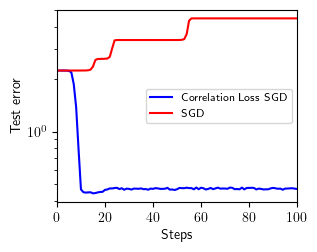

In [5]:
fig, ax = plt.subplots(1,1,figsize=(3.1,2.5))

print(gd_adaptive.predictor_interaction, gd_adaptive.test_errors[-1], gd_adaptive.test_errors[-1]/gd_adaptive.test_errors[0])

R0 = 1.0
# ax.plot(sim_adaptivesgd_test_errors/R0, label=f'Adaptive SGD', marker='', ls='-', color='green')
ax.plot(sim_correlationsgd_test_errors/R0, label=f'Correlation Loss SGD', marker='', ls='-', color='blue')
ax.plot(sim_plainsgd_test_errors/R0, label=f'SGD', marker='', ls='-', color='red')

# ax.plot(theo_adaptivesgd_test_errors, label=f'Adaptive SGD Theory', marker='.', linestyle='-', color='green')
# ax.plot(theo_correlationsgd_test_errors, label=f'Correlation Loss SGD Theory', marker='.', linestyle='-', color='blue')
# ax.plot(theo_plainsgd_test_errors, label=f'SGD Theory', marker='.', linestyle='-', color='red')

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Steps')
ax.set_ylabel('Test error')
ax.set_xlim([0,T])
# ax.set_ylim([2,5])
ax.legend(fontsize=8, loc='center right')

plt.savefig('figures/multiindex_SGD.pdf', bbox_inches = 'tight')

